In [1]:
import numpy as np

import pint
ureg = pint.UnitRegistry(system='mks')

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

from collections.abc import Iterable


In [2]:
def si(v):
    
    return v.to_base_units().magnitude

In [3]:
class Rocket():
    
    def __init__(self):
        
        self.components = []
        
        self.boat_tail = None
        self.fins = None
        
        return
     
    def add(self, component):
        if isinstance(component, Iterable):
            self.components.extend(component)
        else:
            self.components.append(component)
            
        return None
    
    def set_boat_tail(self, component):
        
        """Set the boat tail component"""
        
        if component in self.components:
            # find the boat tail in the list of components
            boat_tail = [comp for comp in self.components if component == comp][0]
        else:
            boat_tail = component
            self.add(component)
            
        self.boat_tail = boat_tail
        
        return None
    
    def set_fins(self, component):
        
        """Set the fin set of the rocket"""
        
        if component in self.components:
        
            # find the fins in the list of components
            fins = [comp for comp in self.components if component == comp][0]
            self.fins = fins
        else:
            fins = component
            self.add(fins)

        self.fins = fins
        return None
        
        
    def plot(self, ax=None,plot_component_cp=False):
        
        if not ax:
            ax = plt.gca()
            
        for comp in self.components:
            comp.plot()
            if plot_component_cp:
                plt.plot(si(comp.pos()+comp.xcp()), 0, 'kx')
            
        # plot xcp
        plt.plot(si(self.xcp()), 0, 'rx')
            
        plt.axis('equal')
        plt.grid()
        
        return None
    
    def length(self):
        return sum(comp.length for comp in self.components)
        
        
    def CNa(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        CNa = sum(comp.CNa(alpha, Re, Mach) for comp in self.components)
        
        return CNa
    
    def CN(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return self.CNa(alpha, Re, Mach) * alpha
        
    def xcp(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        xcp = sum(comp.CNa(alpha, Re, Mach) * (comp.pos() + comp.xcp(alpha, Re, Mach)) for comp in self.components) / self.CNa(alpha, Re, Mach)
        
        return xcp
    
    def CD(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        """Calculate the drag force at some angle of attack, including compressibility"""
        
        CD0 = self.CD0(Re)
        CD_body_alpha = 0
        CD_fins_alpha = 0
        
        CD = CD0 + CD_body_alpha + CD_fins_alpha
        
        return CD
    
    def CD_body_alpha(self, alpha=0*ureg.rad):
        
        alpha = alpha.to(ureg.rad).magnitude # ensure its in radians
        
        raise NotImplementedError
        
        #TODO: need to implement this.
        delta = self.delta(alpha)
        eta = self.eta(alpha)
        
        2*delta*alpha**2 + (3.6 * eta * ((1.36 * l_TR - 0.55* l_n))/(np.pi * d_b**2)) * alpha**3
        
        return 0.0
        
    def CD0(self, Re=1e6):
        """Calcualte the zero angle-of-attack incompressible drag of the rocket. 
        Generally uses DATCOM method (as specified by Box [1])
        Reynolds number refers to the reynolds number by the length of the rocket. """
        
        CD0_fb = self.CD0_fb(Re)
        CD0_b  = self.CD0_b(Re)
        CD0_f  = self.CD0_f(Re)
        
        return CD0_fb + CD0_b + CD0_f
    
    def CD0_fb(self, Re=1e6):
        """Calcualte the zero-angle of attack drag due to forebody of the rocket"""
        
        #total length of the rocket
        l_TR = self.length()
        
        if self.boat_tail is not None:
            # length of the boat tail
            l_c = self.boat_tail.length
            # diameter at boat tail
            d_d = self.boat_tail.aft_dia
        else:
            l_c = 0*ureg.m;
            d_d = 0*ureg.m;
        
        # maximum body diameter of rocket
        d_b = max([comp.diameter for comp in self.components if type(comp) is BodyTube])
        
        # length of body tube
        l_b = sum([comp.length for comp in self.components if type(comp) is BodyTube])
        
        # length of nose cone
        l_n = sum([comp.length for comp in self.components if type(comp) is ConicalNose])
        # coefficient of friction of fore body
        Cf_fb = self.Cf(Re=Re)
        
        CD0_fb = (1+60/(l_TR/d_b)**3 + 0.0025*(l_b/d_b))*(2.7*(l_n/d_b) + 4*(l_b/d_b) + 2*(1 - d_d/d_b)*(l_c/d_b))*Cf_fb
        
        return CD0_fb
    
    def CD0_b(self, Re=1e6):
        """Calcualte the zero-angle of attack drag due to base drag"""
        
        if self.boat_tail is None:
            raise NotImplementedError
        else:
            # find max dia
            d_b = max([comp.diameter for comp in self.components if type(comp) is BodyTube])
            # find boat dia aft dia
            d_d = self.boat_tail.aft_dia
            
        CD0_b = 0.029*(d_d/d_b)**3/(self.CD0_fb(Re))**0.5
            
        
        return CD0_b
    
    def CD0_f(self, Re=1e6):
        """Calcualte the zero-angle of attack drag due to the fins, including the effect of the interference"""
        
        if self.fins is None:
            raise RuntimeError("Please define the fins using rocket.set_fins(fins) first.")
        
        l_TR = self.length()
        
        l_m_fins = self.fins.mid_chord_span
        t_f = self.fins.thickness
        A_fp = self.fins.planform_area
        A_fe = self.fins.exposed_area
        d_f = self.fins.tube_dia
        n = self.fins.n
        
        Re_fins = Re*(l_m_fins/l_TR)
        Cf_f = self.Cf(Re_fins)
        
        
        CD0_f = 2 * Cf_f * (1 + 2*t_f/l_m_fins) * (4 * n * (2*A_fp - A_fe)) / (np.pi * d_f**2)
        
        return CD0_f
    
    def Cf(self, Re=1e6):
        """Return the viscous friction coefficient at a Reynolds number"""
        
        Re_c = 5e5; #critical reynolds number for transition
        
        if Re < Re_c:
            Cf = 1.328/np.sqrt(Re)
            return Cf
        
        else:
            B = Re_c*(0.074*Re**(-0.2) - 1.328*Re**(-0.5))
            
            Cf = 0.074*Re**(-0.2) - B/Re
            
            return Cf

In [4]:
class ConicalNose():
    
    def __init__(self, diameter=None, length=None, fineness=None):
        
        if diameter and length:
            self.diameter = diameter
            self.length = length
        elif diameter and fineness:
            self.diameter = diameter
            self.length = fineness*self.diameter     
        elif length and diameter:
            self.length = length
            self.diameter = length/fineness
            
        self.ref_dia = self.diameter
            
    def __repr__(self):
        
        s = f'Nose Cone (D={self.diameter}, L={self.length})'
        
        return s
    
    def CNa(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        # eq 25 of [1]
        return 2/(1*ureg.rad) # per radian
    
    def CN(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return self.CNa(alpha, Re, Mach)*alpha
    
    def xcp(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return (2/3)*self.length
    
    def pos(self):
        
        # get the position of the nose cone
        return 0*ureg.m
    
    def plot(self, ax=None):
        
        l = si(self.length)
        r = si(self.diameter)/2
        
        coords = np.array([[0, 0], [l, r], [l, -r]])
        
        poly = Polygon(coords,facecolor='none',edgecolor='k')
        
        if ax:
            return ax.add_patch(poly)
        else:
            ax = plt.gca()
            return ax.add_patch(poly)

    
class Transition():
    
    def __init__(self, attached_to=None, fore_dia=None, aft_dia=None, length=None):

        self.attached_to = attached_to
        self.fore_dia = fore_dia
        self.aft_dia = aft_dia
        self.ref_dia = attached_to.ref_dia
        self.length = length
        
        
    def __repr__(self):
        
        s = f'Transition, (D_fore = {self.fore_dia}, D_aft = {self.aft_dia}, L={self.length})'
        
        return s
    
    def pos(self):
        
        return self.attached_to.length + self.attached_to.pos()
    
    def CNa(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return 2*((self.aft_dia/self.ref_dia)**2 - (self.fore_dia/self.ref_dia)**2) / (1*ureg.rad)
    
    def CN(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return self.CNa(alpha, Re, Mach) * alpha
    
    def xcp(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        d_fore = self.fore_dia
        d_aft = self.aft_dia
        
        #eqn 40 of ref[1]
        return (self.length/3) * ((d_fore + 2 * d_aft)/(d_fore + d_aft))
    
    def plot(self, ax=None):
        
        l = si(self.length)
        fore_r = si(self.fore_dia)/2
        aft_r = si(self.aft_dia)/2
        
        pos = si(self.pos())
        
        coords = np.array([[pos, fore_r], [pos+l, aft_r], [pos+l, -aft_r],[pos, -fore_r]])
        
        poly = Polygon(coords,facecolor='none',edgecolor='k')
        
        if ax:
            return ax.add_patch(poly)
        else:
            ax = plt.gca()
            return ax.add_patch(poly)


class BodyTube():
    
    
    def __init__(self, attached_to = None, diameter=None, length=None):
        
        self.attached_to = attached_to
        self.ref_dia = attached_to.ref_dia
        
        if diameter:
            self.diameter = diameter
        else:
            self.diameter = self.attached_to.ref_dia
        
        self.length = length
        
    def pos(self):
        
        return self.attached_to.length + self.attached_to.pos()
    
    def __repr__(self):
        
        s = f'Body Tube (D={self.diameter}, L={self.length})'
        
        return s
    
    def plot(self, ax=None):
        
        l = si(self.length)
        r = si(self.diameter)/2
        
        pos = si(self.pos())
        
        coords = np.array([[pos, r], [pos+l, r], [pos+l, -r],[pos, -r]])
        
        poly = Polygon(coords,facecolor='none',edgecolor='k')
        
        if ax:
            return ax.add_patch(poly)
        else:
            ax = plt.gca()
            return ax.add_patch(poly)
        
        
    def CNa(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3, K=1.25):
        
        planform_area = self.diameter * self.length
        ref_area = np.pi*(self.ref_dia/2)**2
        
        return (K*planform_area/ref_area) * alpha /((1*ureg.rad)**2)
    
    def CN(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3, K=1.25):
        
        return self.CNa(alpha, Re, Mach, K) * alpha
    
    
    def xcp(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return self.length/2
    
    
        
    
class FinSet():
    
    def __init__(self, attached_to=None, n=None, span=None, root_chord=None, tip_chord=None, mid_sweep=None, thickness=None):
        
        # midsweep is the sweep angle at the mid-chord locations
        # attached_to tells you which body tube it is attached to, and inherits important info from there
        
        self.attached_to = attached_to
        self.ref_dia = attached_to.ref_dia
        
        self.n = n
        self.span = span
        self.root_chord = root_chord
        self.tip_chord = tip_chord
        self.mid_sweep = mid_sweep
        self.mid_chord_span = self.span/np.cos(self.mid_sweep)
        
        self.tube_dia = self.attached_to.diameter
        self.length = 0 # used in calculating the overall length of the rocket
        self.thickness = thickness
        
        self.exposed_area = 0.5 * (self.root_chord + self.tip_chord) * self.span # per fin
        self.planform_area = self.exposed_area + 0.5 * self.tube_dia * self.root_chord # per fin        
        
        
    def pos(self):
        
        return self.attached_to.length + self.attached_to.pos() - self.root_chord
        
    def __repr__(self):
        
        s = f'Fin set'
        
        return s
    
    def CNa(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        

        
        if self.n <= 4:
            body_influence = 1 +     (self.tube_dia/2)/(self.span + self.tube_dia/2)
        elif self.n > 4:
            body_influence = 1 + 0.5*(self.tube_dia/2)/(self.span + self.tube_dia/2)
        
        CNa = body_influence * (4*self.n*(self.span/self.ref_dia)**2) / (1 + (1 + (self.mid_chord_span/(self.root_chord + self.tip_chord))**2)**0.5)
        
        
        return CNa / (1*ureg.rad)
    
    def CN(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        return self.CNa(alpha, Re, Mach) * alpha
    
    def xcp(self, alpha=0*ureg.rad, Re=1e6, Mach=0.3):
        
        lm = self.mid_chord_span
        lr = self.root_chord
        lt = self.tip_chord
        
        a = lm * (lr + lt) / (3 * (lr + lt))
        b = (1/6) * (lr + lt - (lr*lt)/(lr + lt))
        
        
        return a + b
    
    def plot(self, ax=None):
        
        pos = si(self.pos())        
        
        r = si(self.tube_dia)/2
        lr = si(self.root_chord)
        lt = si(self.tip_chord)
        lm = si(self.mid_chord_span)
        ls = si(self.span)
        sweep = si(self.mid_sweep)
        
        tip_le = lr/2 + ls*np.tan(sweep) - lt/2 #tip leading edge
        
        
        coords = np.array([[pos, r], [pos+tip_le , r + ls], [pos + tip_le + lt, r + ls], [pos + lr, r]])
        
        th_set = np.linspace(0, 2*np.pi, self.n, endpoint=False)
        
        poly_set = []
        for th in th_set:
            R2 = np.array([[1, 0 ], [0, np.cos(th)]])
            coords2 = (R2 @ coords.T).T
            poly = Polygon(coords2,facecolor='none',edgecolor='k')
            poly_set.append(poly)
            
        
        if not ax:
            ax = plt.gca()
            
            
        for poly in poly_set:
            ax.add_patch(poly)        
        
        return None
        
        
    
    #references:
    #[1]: Simon Box, 2009, Estimating the dynamic and aerodynamic paramters of passively controlled high power rockets for flight simulaton
        

In [5]:
nc = ConicalNose(diameter=6*ureg.inch, length=18*ureg.inch)

(-0.022860000000000002, 0.48006, -0.08381999999999999, 0.08381999999999999)

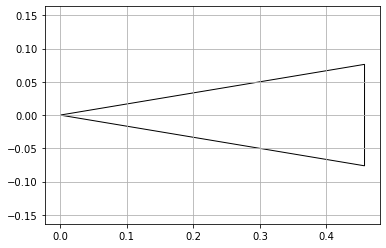

In [6]:
fig = plt.figure()
ax = plt.gca()

plt.grid()
nc.plot()

plt.axis('equal')



In [7]:
nc

Nose Cone (D=6 inch, L=18 inch)

In [8]:
nc.CNa()*0.2*ureg.rad

0.4 <Unit('dimensionless')>

In [9]:
nc.CN(0.2*ureg.rad)

0.4 <Unit('dimensionless')>

In [10]:
bt = BodyTube(attached_to=nc, diameter=6*ureg.inch, length=48*ureg.inch)

In [11]:
trans1 = Transition(attached_to=bt, fore_dia=6*ureg.inch, aft_dia=4*ureg.inch, length=4*ureg.inch)

In [12]:
trans1

Transition, (D_fore = 6 inch, D_aft = 4 inch, L=4 inch)

In [13]:
trans1.CNa()

-1.1111111111111112 <Unit('1 / radian')>

In [37]:
fins = FinSet(attached_to=bt, n=3, span=6*ureg.inch, root_chord=12*ureg.inch, tip_chord=6*ureg.inch, mid_sweep=10*ureg.degree, thickness=6*ureg.mm)

In [38]:
components = [nc, bt, trans1, fins]

In [39]:
r = Rocket()

In [40]:
r.add(nc)

In [41]:
r.add([bt, trans1])

In [42]:
r.set_boat_tail(trans1)
r.set_fins(fins)

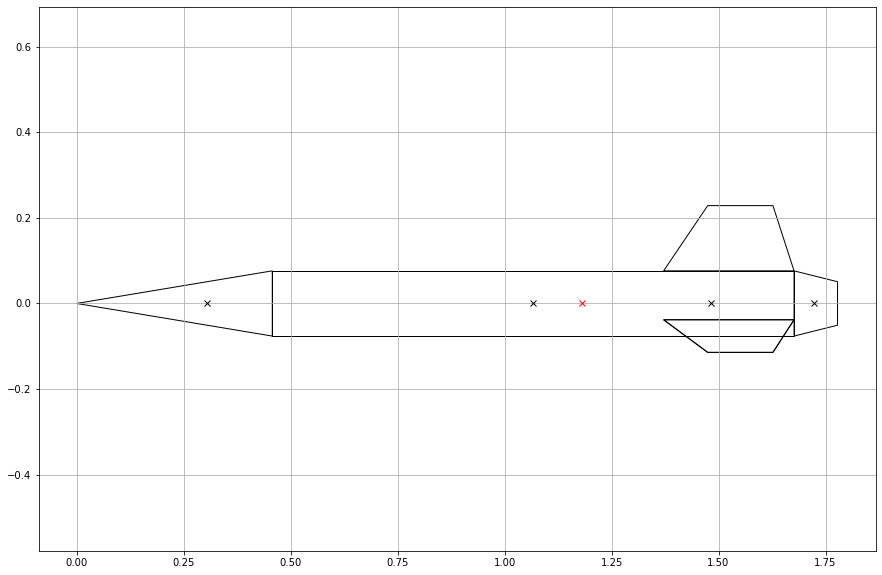

In [43]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
r.plot(ax, plot_component_cp=True)

In [44]:
r.xcp()

1.1799275034283525 <Unit('meter')>

In [45]:
r.components[0].xcp()

12.0 <Unit('inch')>

In [46]:
r.CNa()

8.672012416372757 <Unit('1 / radian')>

In [47]:
alpha=0.01*ureg.rad
Re = 0
Mach = 0
xcp=sum(comp.CNa(alpha, Re, Mach) * (comp.pos() + comp.xcp(alpha, Re, Mach)) for comp in r.components) / r.CNa(alpha, Re, Mach)
si(xcp)

1.1782905798594416

In [48]:
sum(comp.length for comp in r.components)

70 <Unit('inch')>

In [49]:
r.components

[Nose Cone (D=6 inch, L=18 inch),
 Body Tube (D=6 inch, L=48 inch),
 Transition, (D_fore = 6 inch, D_aft = 4 inch, L=4 inch),
 Fin set]

In [50]:
alphas = np.linspace(0, np.pi/2)*ureg.rad
CNs = [bt.CN(alpha) for alpha in alphas]

/Users/Devansh/anaconda3/lib/python3.6/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


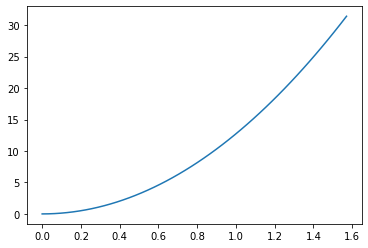

In [51]:
plt.plot(alphas, CNs)

In [52]:
pos_list = [si(comp.pos()) for comp in r.components]
pos_list

[0, 0.4572, 1.6764, 1.3716]

In [53]:
ind=pos_list.index(max(pos_list))
ind

2

In [54]:
r.components[ind]

Transition, (D_fore = 6 inch, D_aft = 4 inch, L=4 inch)

In [55]:
r

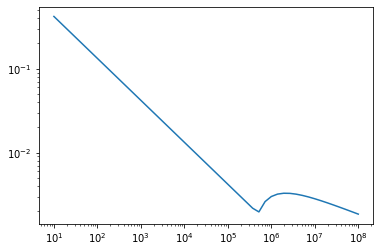

In [56]:
re_vals = np.logspace(1, 8)
plt.loglog(re_vals, [r.Cf(re) for re in re_vals])

In [57]:
r.components

[Nose Cone (D=6 inch, L=18 inch),
 Body Tube (D=6 inch, L=48 inch),
 Transition, (D_fore = 6 inch, D_aft = 4 inch, L=4 inch),
 Fin set]

In [58]:
trans1

Transition, (D_fore = 6 inch, D_aft = 4 inch, L=4 inch)

In [59]:
r.CD0()

0.24519710410228923 <Unit('dimensionless')>

Text(0, 0.5, 'CD0 of Rocket')

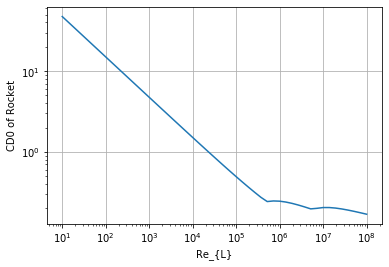

In [63]:
plt.loglog(re_vals, [r.CD0(re) for re in re_vals])
plt.grid()
plt.xlabel("Re_{L}")
plt.ylabel("CD0 of Rocket")

In [61]:
fins.planform_area

90.0 <Unit('inch ** 2')>

In [64]:
alpha = 5*ureg.degree

In [65]:
alpha

5 <Unit('degree')>

0.08726646259971647

In [73]:
alpha.magnitude

5